In [ ]:
# Imports & config
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import timm  # for ViT backbone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)

import matplotlib.pyplot as plt
import itertools

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
import os

data_dir = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"
classes = os.listdir(data_dir)
for cls in classes:
    print(f"Class: {cls}, Number of Images: {len(os.listdir(os.path.join(data_dir, cls)))}")

Class: 1Gallstones, Number of Images: 1326
Class: 2Abdomen and retroperitoneum, Number of Images: 1170
Class: 3cholecystitis, Number of Images: 1146
Class: 4Membranous and gangrenous cholecystitis, Number of Images: 1224
Class: 5Perforation, Number of Images: 1062
Class: 6Polyps and cholesterol crystals, Number of Images: 1020
Class: 7Adenomyomatosis, Number of Images: 1164
Class: 8Carcinoma, Number of Images: 1590
Class: 9Various causes of gallbladder wall thickening, Number of Images: 990


In [3]:
from PIL import Image

image_sizes = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        img = Image.open(os.path.join(data_dir, cls, img_file))
        image_sizes.append(img.size)

print(set(image_sizes))  # Unique image sizes

{(2400, 1800), (1170, 876), (900, 1200), (1200, 900)}


In [4]:
corrupted_images = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        try:
            img = Image.open(os.path.join(data_dir, cls, img_file))
            img.verify()  # Check for corruption
        except (IOError, SyntaxError):
            corrupted_images.append(img_file)

print("Corrupted Images:", corrupted_images)

Corrupted Images: []


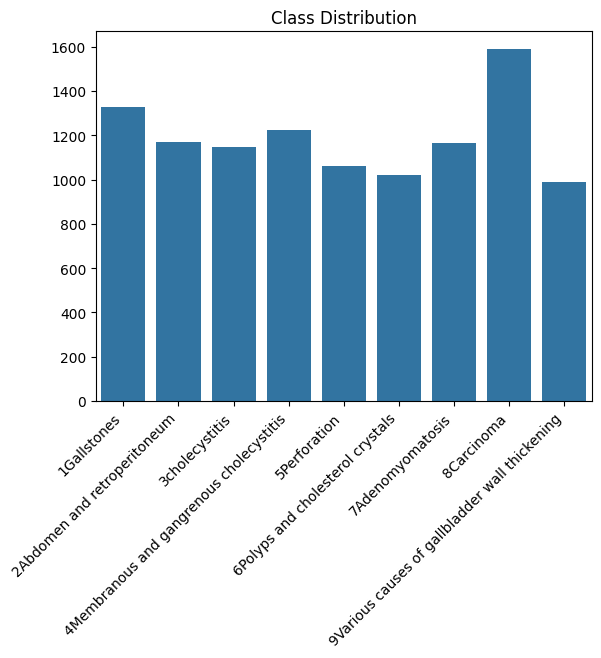

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]
sns.barplot(x=classes, y=class_counts)
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.show()

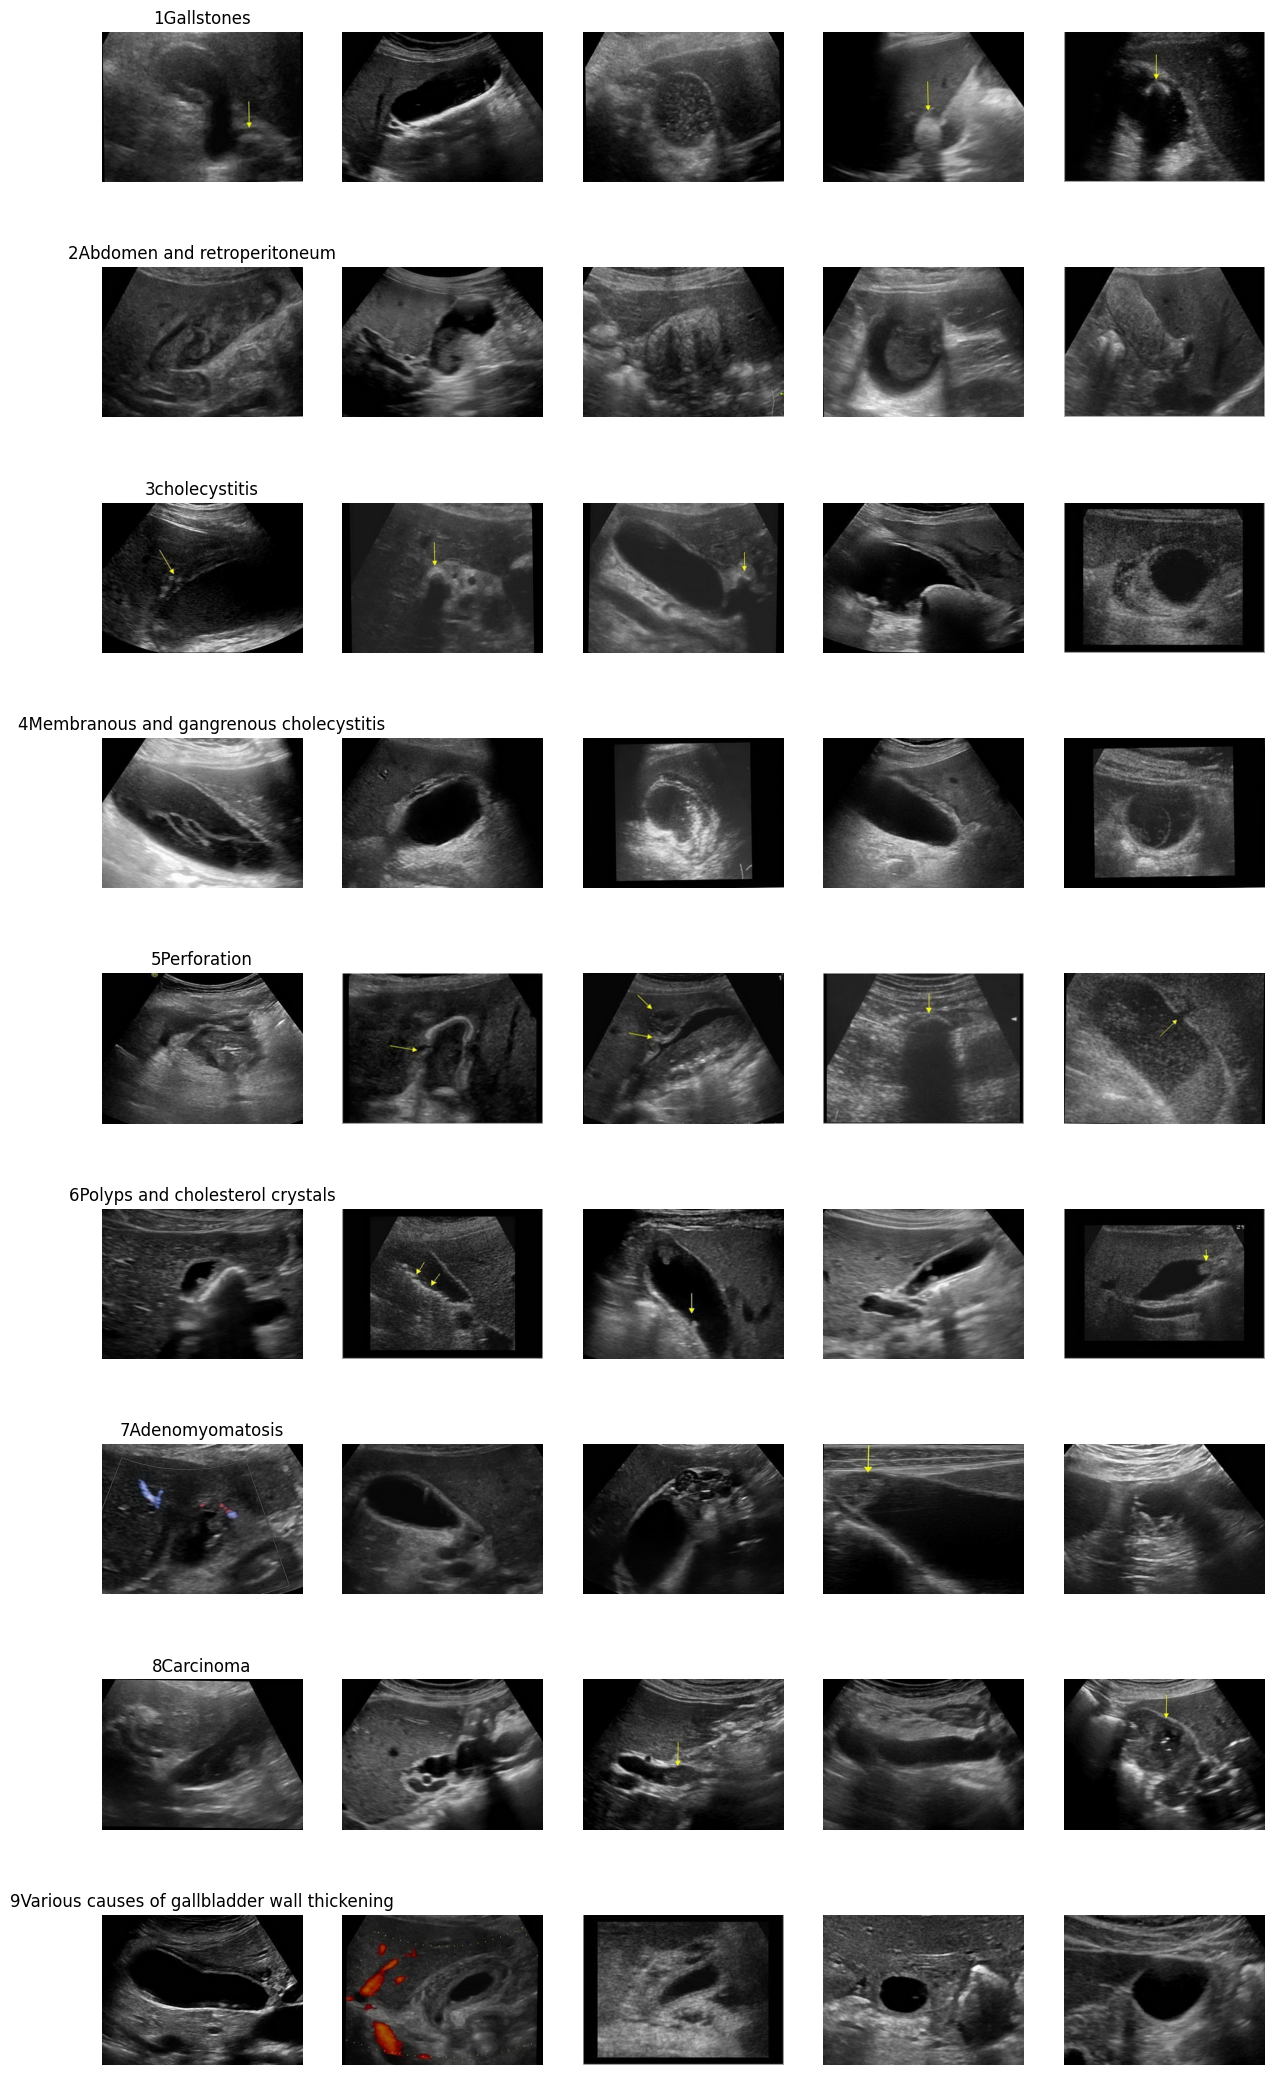

In [6]:
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    for j in range(5):
        img_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(cls)
plt.show()

In [ ]:
# Paths & hyperparameters
DATA_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"  

OUTPUT_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Image + model hyperparams
IMAGE_SIZE = 224         
BATCH_SIZE_PRETRAIN = 64
BATCH_SIZE_FINETUNE = 32
NUM_WORKERS = 0

MAE_EPOCHS = 50
MAE_LR = 1e-4
MASK_RATIO = 0.75        # proportion of patches to mask in MAE

FINETUNE_EPOCHS = 50
FINETUNE_LR = 3e-4

# Logging / saving files
MAE_ENCODER_WEIGHTS = os.path.join(OUTPUT_DIR, "mae_encoder.pth")
FINETUNE_WEIGHTS = os.path.join(OUTPUT_DIR, "finetune_classifier.pth")

# Helpers
def save_checkpoint(state, path):
    torch.save(state, path)

def imshow_tensor(img_tensor, title=None):
    img = img_tensor.cpu().permute(1,2,0).numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')


In [ ]:
# Build file list & stratified splits
root = Path(DATA_DIR)
classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
if len(classes) == 0:
    raise RuntimeError(f"No class subfolders found in {DATA_DIR}. Put images in subfolders per class.")

print("Classes:", classes)

# Gather (filepath, label) pairs
items = []
for i, cls in enumerate(classes):
    cls_dir = root / cls
    for p in cls_dir.iterdir():
        if p.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"):
            items.append((str(p), i))
print("Total images found:", len(items))

# Stratified split: train_val and test first, then split train_val into train/val
paths, labels = zip(*items)
paths = np.array(paths)
labels = np.array(labels)

# First split out a test set 
test_size = 0.10
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(
    paths, labels, test_size=test_size, stratify=labels, random_state=SEED)

# Then split trainval into train and val
val_size = 0.111  # fraction of trainval for validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    trainval_paths, trainval_labels, test_size=val_size, stratify=trainval_labels, random_state=SEED)

print("Split counts:")
print("  Train:", len(train_paths))
print("  Val:  ", len(val_paths))
print("  Test: ", len(test_paths))
print("Per-class distribution in train:", Counter(train_labels))
print("Per-class distribution in val:  ", Counter(val_labels))
print("Per-class distribution in test: ", Counter(test_labels))


Classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening']
Total images found: 10692
Split counts:
  Train: 8553
  Val:   1069
  Test:  1070
Per-class distribution in train: Counter({np.int64(7): 1272, np.int64(0): 1060, np.int64(3): 979, np.int64(1): 936, np.int64(6): 932, np.int64(2): 916, np.int64(4): 850, np.int64(5): 816, np.int64(8): 792})
Per-class distribution in val:   Counter({np.int64(7): 159, np.int64(0): 133, np.int64(3): 122, np.int64(1): 117, np.int64(6): 116, np.int64(2): 115, np.int64(4): 106, np.int64(5): 102, np.int64(8): 99})
Per-class distribution in test:  Counter({np.int64(7): 159, np.int64(0): 133, np.int64(3): 123, np.int64(1): 117, np.int64(6): 116, np.int64(2): 115, np.int64(4): 106, np.int64(5): 102, np.int64(8): 99})


In [ ]:
# Dataset classes
class ImageFolderList(Dataset):
    """Loads images from a list of file paths. Optionally returns labels."""
    def __init__(self, paths, labels=None, transform=None, return_label=True):
        self.paths = list(paths)
        self.labels = list(labels) if labels is not None else None
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.return_label and self.labels is not None:
            return img, self.labels[idx]
        else:
            return img

# Transforms
pretrain_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

finetune_train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

finetune_eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Datasets & dataloaders
pretrain_dataset = ImageFolderList(train_paths, labels=None, transform=pretrain_transform, return_label=False)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE_PRETRAIN, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

train_dataset = ImageFolderList(train_paths, labels=train_labels, transform=finetune_train_transform, return_label=True)
val_dataset   = ImageFolderList(val_paths,   labels=val_labels,   transform=finetune_eval_transform,  return_label=True)
test_dataset  = ImageFolderList(test_paths,  labels=test_labels,  transform=finetune_eval_transform,  return_label=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_FINETUNE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE_FINETUNE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE_FINETUNE, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
class MAE_DeiT(nn.Module):
    def __init__(self, encoder_name = 'deit_base_patch16_224',mask_ratio=0.75, img_size=224, patch_size=16, decoder_dim=512, decoder_depth=6):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.img_size = img_size
        self.patch_size = patch_size

        # Load DeiT Base Patch16 224
        self.encoder_name = encoder_name
        self.deit = timm.create_model(encoder_name, pretrained=False)
        self.patch_embed = self.deit.patch_embed
        self.cls_token = nn.Parameter(self.deit.cls_token.clone())
        self.pos_embed = nn.Parameter(self.deit.pos_embed.clone())
        self.blocks = self.deit.blocks
        self.norm = self.deit.norm
        self.deit.head = nn.Identity()  # remove classification head

        # Patchify / Unpatchify
        self.patchify = Patchify(patch_size)
        self.unpatchify = Unpatchify(patch_size)

        # Decoder
        embed_dim = self.patch_embed.proj.out_channels
        num_patches = self.patch_embed.num_patches
        self.embed_dim = embed_dim
        self.num_patches = num_patches

        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_dim))

        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=16, batch_first=True)
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=decoder_depth)
        self.decoder_pred = nn.Linear(decoder_dim, patch_size*patch_size*3)

    def forward(self, imgs):
        B = imgs.size(0)
        # Patchify
        patches = self.patchify(imgs)  # [B, N, patch_dim]

        # Encoder patch embedding
        x = self.patch_embed(imgs)  # [B, N, embed_dim]

        # Random masking
        N = x.shape[1]
        len_keep = int(N * (1 - self.mask_ratio))
        noise = torch.rand(B, N, device=imgs.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1,1,x.shape[2]))

        # Add CLS token + batch-wise positional embedding
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x_masked = torch.cat([cls_tokens, x_masked], dim=1)

        # Positional embeddings
        pos_cls = self.pos_embed[:, :1, :].expand(B, -1, -1)
        pos_patch = self.pos_embed[:, 1:, :].expand(B, -1, -1)
        pos_patch = torch.gather(pos_patch, 1, ids_keep.unsqueeze(-1).repeat(1,1,pos_patch.shape[2]))
        pos_embed_vis = torch.cat([pos_cls, pos_patch], dim=1)
        x_masked = x_masked + pos_embed_vis

        # Transformer encoder
        x_masked = self.blocks(x_masked)
        x_masked = self.norm(x_masked)

        # Remove CLS token for decoder
        x_enc = x_masked[:, 1:, :]  # [B, N_visible, embed_dim]

        # Insert mask tokens
        N_visible = x_enc.shape[1]
        mask_tokens = self.mask_token.expand(B, N - N_visible, -1)
        x_full = torch.cat([x_enc, mask_tokens], dim=1)

        # Restore original token order
        x_full = torch.gather(x_full, 1, ids_restore.unsqueeze(-1).repeat(1,1,x_full.shape[2]))

        # Decoder
        x_full = self.decoder_embed(x_full)
        x_full = x_full + self.decoder_pos_embed
        x_full = self.decoder(x_full)

        # Predict patches
        pred = self.decoder_pred(x_full)  # [B, N, patch_dim]

        # Create mask for loss
        mask = torch.ones(B, N, device=imgs.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, 1, ids_restore)

        return pred, patches, mask  # B,N,patch_dim, B,N,patch_dim, B,N


In [ ]:
# Patchify / Unpatchify
class Patchify(nn.Module):
    def __init__(self, patch_size=16):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, imgs):
        B, C, H, W = imgs.shape
        p = self.patch_size
        assert H % p == 0 and W % p == 0
        h, w = H // p, W // p
        patches = imgs.unfold(2, p, p).unfold(3, p, p)
        patches = patches.permute(0,2,3,1,4,5).contiguous()
        patches = patches.reshape(B, h*w, C*p*p)
        return patches


class Unpatchify(nn.Module):
    def __init__(self, patch_size=16):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, patches, img_size=224):
        B, N, D = patches.shape
        p = self.patch_size
        h = w = img_size // p
        patches = patches.reshape(B, h, w, 3, p, p)
        patches = patches.permute(0,3,1,4,2,5).contiguous()
        imgs = patches.reshape(B, 3, img_size, img_size)
        return imgs

# MAE-DeiT Model
class MAE_DeiT(nn.Module):
    def __init__(self, encoder_name='deit_base_patch16_224', mask_ratio=0.75, img_size=224,
                 patch_size=16, decoder_dim=512, decoder_depth=6):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.img_size = img_size
        self.patch_size = patch_size

        # Load DeiT Base
        self.deit = timm.create_model(encoder_name, pretrained=False)
        self.patch_embed = self.deit.patch_embed
        self.cls_token = nn.Parameter(self.deit.cls_token.clone())
        self.pos_embed = nn.Parameter(self.deit.pos_embed.clone())
        self.blocks = self.deit.blocks
        self.norm = self.deit.norm
        self.deit.head = nn.Identity()  # remove classification head

        # Patchify / Unpatchify
        self.patchify = Patchify(patch_size)
        self.unpatchify = Unpatchify(patch_size)

        # Decoder
        embed_dim = self.patch_embed.proj.out_channels
        num_patches = self.patch_embed.num_patches
        self.embed_dim = embed_dim
        self.num_patches = num_patches

        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_dim))

        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=16, batch_first=True)
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=decoder_depth)
        self.decoder_pred = nn.Linear(decoder_dim, patch_size*patch_size*3)

    def forward(self, imgs):
        B = imgs.size(0)
        # Patchify
        patches = self.patchify(imgs)

        # Encoder patch embedding
        x = self.patch_embed(imgs)

        # Random masking
        N = x.shape[1]
        len_keep = int(N * (1 - self.mask_ratio))
        noise = torch.rand(B, N, device=imgs.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1,1,x.shape[2]))

        # Add CLS token + positional embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x_masked = torch.cat([cls_tokens, x_masked], dim=1)

        pos_cls = self.pos_embed[:, :1, :].expand(B, -1, -1)
        pos_patch = torch.gather(
            self.pos_embed[:, 1:, :].expand(B, -1, -1),
            1,
            ids_keep.unsqueeze(-1).repeat(1,1,self.embed_dim)
        )
        pos_embed_vis = torch.cat([pos_cls, pos_patch], dim=1)
        x_masked = x_masked + pos_embed_vis

        # Encoder
        x_masked = self.blocks(x_masked)
        x_masked = self.norm(x_masked)

        # Remove CLS token for decoder
        x_enc = x_masked[:, 1:, :]

        # Insert mask tokens
        N_visible = x_enc.shape[1]
        mask_tokens = self.mask_token.expand(B, N - N_visible, -1)
        x_full = torch.cat([x_enc, mask_tokens], dim=1)

        # Restore original order
        x_full = torch.gather(x_full, 1, ids_restore.unsqueeze(-1).repeat(1,1,x_full.shape[2]))

        # Decoder
        x_full = self.decoder_embed(x_full)
        x_full = x_full + self.decoder_pos_embed
        x_full = self.decoder(x_full)

        # Predict patches
        pred = self.decoder_pred(x_full)

        return pred, patches

MAE Epoch 1/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 1 completed. MAE reconstruction loss: 0.533457


MAE Epoch 2/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 2 completed. MAE reconstruction loss: 0.356949


MAE Epoch 3/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 3 completed. MAE reconstruction loss: 0.346299


MAE Epoch 4/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 4 completed. MAE reconstruction loss: 0.334906


MAE Epoch 5/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 5 completed. MAE reconstruction loss: 0.324381


MAE Epoch 6/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 6 completed. MAE reconstruction loss: 0.310255


MAE Epoch 7/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 7 completed. MAE reconstruction loss: 0.295726


MAE Epoch 8/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 8 completed. MAE reconstruction loss: 0.283552


MAE Epoch 9/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 9 completed. MAE reconstruction loss: 0.270414


MAE Epoch 10/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 10 completed. MAE reconstruction loss: 0.257998


MAE Epoch 11/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 11 completed. MAE reconstruction loss: 0.248248


MAE Epoch 12/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 12 completed. MAE reconstruction loss: 0.239357


MAE Epoch 13/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 13 completed. MAE reconstruction loss: 0.225990


MAE Epoch 14/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 14 completed. MAE reconstruction loss: 0.209327


MAE Epoch 15/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 15 completed. MAE reconstruction loss: 0.189752


MAE Epoch 16/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 16 completed. MAE reconstruction loss: 0.174293


MAE Epoch 17/50: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s]


MAE Epoch 17 completed. MAE reconstruction loss: 0.164656


MAE Epoch 18/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 18 completed. MAE reconstruction loss: 0.156138


MAE Epoch 19/50: 100%|██████████| 133/133 [01:18<00:00,  1.71it/s]


MAE Epoch 19 completed. MAE reconstruction loss: 0.150303


MAE Epoch 20/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 20 completed. MAE reconstruction loss: 0.144952


MAE Epoch 21/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 21 completed. MAE reconstruction loss: 0.141634


MAE Epoch 22/50: 100%|██████████| 133/133 [01:16<00:00,  1.73it/s]


MAE Epoch 22 completed. MAE reconstruction loss: 0.138796


MAE Epoch 23/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 23 completed. MAE reconstruction loss: 0.135549


MAE Epoch 24/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 24 completed. MAE reconstruction loss: 0.132919


MAE Epoch 25/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 25 completed. MAE reconstruction loss: 0.130232


MAE Epoch 26/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 26 completed. MAE reconstruction loss: 0.127145


MAE Epoch 27/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 27 completed. MAE reconstruction loss: 0.126555


MAE Epoch 28/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 28 completed. MAE reconstruction loss: 0.125013


MAE Epoch 29/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 29 completed. MAE reconstruction loss: 0.123132


MAE Epoch 30/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 30 completed. MAE reconstruction loss: 0.120593


MAE Epoch 31/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 31 completed. MAE reconstruction loss: 0.120064


MAE Epoch 32/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 32 completed. MAE reconstruction loss: 0.117960


MAE Epoch 33/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 33 completed. MAE reconstruction loss: 0.116420


MAE Epoch 34/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 34 completed. MAE reconstruction loss: 0.115381


MAE Epoch 35/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 35 completed. MAE reconstruction loss: 0.114008


MAE Epoch 36/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 36 completed. MAE reconstruction loss: 0.113400


MAE Epoch 37/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 37 completed. MAE reconstruction loss: 0.111089


MAE Epoch 38/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 38 completed. MAE reconstruction loss: 0.110200


MAE Epoch 39/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 39 completed. MAE reconstruction loss: 0.110128


MAE Epoch 40/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 40 completed. MAE reconstruction loss: 0.109138


MAE Epoch 41/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 41 completed. MAE reconstruction loss: 0.108046


MAE Epoch 42/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 42 completed. MAE reconstruction loss: 0.107521


MAE Epoch 43/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 43 completed. MAE reconstruction loss: 0.107044


MAE Epoch 44/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 44 completed. MAE reconstruction loss: 0.105780


MAE Epoch 45/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 45 completed. MAE reconstruction loss: 0.105219


MAE Epoch 46/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 46 completed. MAE reconstruction loss: 0.105000


MAE Epoch 47/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 47 completed. MAE reconstruction loss: 0.103764


MAE Epoch 48/50: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s]


MAE Epoch 48 completed. MAE reconstruction loss: 0.102459


MAE Epoch 49/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 49 completed. MAE reconstruction loss: 0.102094


MAE Epoch 50/50: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s]


MAE Epoch 50 completed. MAE reconstruction loss: 0.102007
Pretraining finished. Encoder saved to: C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\mae_encoder.pth


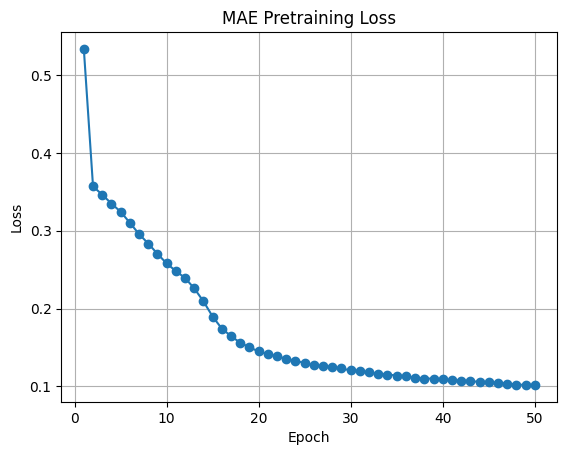

In [ ]:
# Pretraining loop
# Build model
mae = MAE_DeiT(encoder_name="deit_base_patch16_224", img_size=IMAGE_SIZE, patch_size=16,
               decoder_dim=512, decoder_depth=3, mask_ratio=MASK_RATIO).to(device)

optimizer = torch.optim.AdamW(mae.parameters(), lr=MAE_LR, weight_decay=0.05)
criterion = nn.MSELoss(reduction='none')  # we'll mask loss per patch

mae.train()
pretrain_losses = []

for epoch in range(1, MAE_EPOCHS+1):
    running_loss = 0.0
    iters = 0
    for batch in tqdm(pretrain_loader, desc=f"MAE Epoch {epoch}/{MAE_EPOCHS}"):
        imgs = batch.to(device)
        optimizer.zero_grad()
        pred_patches, target_patches= mae(imgs)  # B,N,patch_dim
        B, N, D = target_patches.shape
        # choose masked indices (random for each batch) to compute loss on them
        mask = (torch.rand(B, N, device=device) < MASK_RATIO).float().unsqueeze(-1)  # B,N,1
        loss_mat = criterion(pred_patches, target_patches)
        loss_per_patch = loss_mat.mean(dim=-1, keepdim=True)
        masked_loss = (loss_per_patch * mask).sum() / (mask.sum().clamp_min(1.0))
        masked_loss.backward()
        optimizer.step()
        running_loss += masked_loss.item()
        iters += 1


    epoch_loss = running_loss / iters
    pretrain_losses.append(epoch_loss)
    print(f"MAE Epoch {epoch} completed. MAE reconstruction loss: {epoch_loss:.6f}")
    # save encoder weights (the vit within mae)
    torch.save({'mae_state_dict': mae.state_dict(), 'epoch': epoch}, MAE_ENCODER_WEIGHTS)
print("Pretraining finished. Encoder saved to:", MAE_ENCODER_WEIGHTS)
# Plot pretrain loss curve
plt.figure()
plt.plot(range(1, len(pretrain_losses)+1), pretrain_losses, marker='o')
plt.title("MAE Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
# Fine-tuning model (DeiT-base)
class ClassifierFromEncoder(nn.Module):
    def __init__(self, mae_model, num_classes):
        super().__init__()

        # DeiT encoder inside MAE_DeiT
        self.encoder = mae_model.deit

        self.num_patches = mae_model.num_patches
        emb_dim = mae_model.embed_dim

        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, emb_dim // 2),
            nn.GELU(),
            nn.Linear(emb_dim // 2, num_classes)
        )

    def forward(self, imgs):
        # forward_features returns CLS + patch tokens
        x = self.encoder.forward_features(imgs)

        if x.shape[1] == self.num_patches + 1:
            cls_token = x[:, 0]
            return self.head(cls_token)

        return self.head(x.mean(dim=1))


# Load encoded weights into a new model
checkpoint = torch.load(MAE_ENCODER_WEIGHTS, map_location=device)
mae_state = checkpoint['mae_state_dict']
# Build a fresh MAEModel and load state to ensure shapes match
mae_for_ft = MAE_DeiT(encoder_name="deit_base_patch16_224", img_size=IMAGE_SIZE, patch_size=16,
                      decoder_dim=512, decoder_depth=3, mask_ratio=MASK_RATIO).to(device)
mae_for_ft.load_state_dict(mae_state, strict=False)  # strict False allows ignoring decoder mismatch if any

num_classes = len(classes)
finetune_model = ClassifierFromEncoder(mae_for_ft, num_classes=num_classes).to(device)

for param in finetune_model.encoder.parameters():
    param.requires_grad = True  # set False to freeze

# Optimizer with differential LR
optimizer_ft = torch.optim.AdamW([
    {'params': finetune_model.encoder.parameters(), 'lr': FINETUNE_LR/5},
    {'params': finetune_model.head.parameters(), 'lr': FINETUNE_LR}
], weight_decay=0.01)
criterion_ft = nn.CrossEntropyLoss()


In [ ]:
# Fine-tune training loop
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, FINETUNE_EPOCHS+1):
    # Training
    finetune_model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for imgs, labels in tqdm(train_loader, desc=f"Finetune Train Epoch {epoch}/{FINETUNE_EPOCHS}"):
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(imgs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_corrects += (preds == labels).sum().item()
        total += imgs.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation
    finetune_model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion_ft(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_corrects += (preds == labels).sum().item()
            total += imgs.size(0)
    epoch_val_loss = running_loss / total
    epoch_val_acc = running_corrects / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch}/{FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Save best
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save({'model_state_dict': finetune_model.state_dict(), 'epoch': epoch, 'val_acc': best_val_acc}, FINETUNE_WEIGHTS)
        print(f"  Saved best finetune model (val_acc={best_val_acc:.4f}) -> {FINETUNE_WEIGHTS}")



Finetune Train Epoch 1/50: 100%|██████████| 268/268 [01:46<00:00,  2.52it/s]


Epoch 1/50 | Train Loss: 2.1751 | Train Acc: 0.1541 | Val Loss: 2.1252 | Val Acc: 0.1796
  Saved best finetune model (val_acc=0.1796) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 2/50: 100%|██████████| 268/268 [01:47<00:00,  2.50it/s]


Epoch 2/50 | Train Loss: 2.0884 | Train Acc: 0.2105 | Val Loss: 2.0653 | Val Acc: 0.2086
  Saved best finetune model (val_acc=0.2086) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 3/50: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s]


Epoch 3/50 | Train Loss: 1.9828 | Train Acc: 0.2454 | Val Loss: 2.0799 | Val Acc: 0.2180
  Saved best finetune model (val_acc=0.2180) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 4/50: 100%|██████████| 268/268 [01:46<00:00,  2.53it/s]


Epoch 4/50 | Train Loss: 1.8930 | Train Acc: 0.2869 | Val Loss: 1.9445 | Val Acc: 0.2638
  Saved best finetune model (val_acc=0.2638) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 5/50: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s]


Epoch 5/50 | Train Loss: 1.7861 | Train Acc: 0.3276 | Val Loss: 2.0141 | Val Acc: 0.2254


Finetune Train Epoch 6/50: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s]


Epoch 6/50 | Train Loss: 1.6742 | Train Acc: 0.3854 | Val Loss: 1.8863 | Val Acc: 0.3143
  Saved best finetune model (val_acc=0.3143) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 7/50: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s]


Epoch 7/50 | Train Loss: 1.5632 | Train Acc: 0.4307 | Val Loss: 1.6784 | Val Acc: 0.4004
  Saved best finetune model (val_acc=0.4004) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 8/50: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s]


Epoch 8/50 | Train Loss: 1.4454 | Train Acc: 0.4774 | Val Loss: 1.5483 | Val Acc: 0.4294
  Saved best finetune model (val_acc=0.4294) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 9/50: 100%|██████████| 268/268 [01:46<00:00,  2.52it/s]


Epoch 9/50 | Train Loss: 1.3131 | Train Acc: 0.5279 | Val Loss: 1.5192 | Val Acc: 0.4518
  Saved best finetune model (val_acc=0.4518) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 10/50: 100%|██████████| 268/268 [01:50<00:00,  2.43it/s]


Epoch 10/50 | Train Loss: 1.1560 | Train Acc: 0.5854 | Val Loss: 1.3353 | Val Acc: 0.5491
  Saved best finetune model (val_acc=0.5491) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 11/50: 100%|██████████| 268/268 [01:48<00:00,  2.46it/s]


Epoch 11/50 | Train Loss: 1.0149 | Train Acc: 0.6455 | Val Loss: 1.4003 | Val Acc: 0.5519
  Saved best finetune model (val_acc=0.5519) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 12/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 12/50 | Train Loss: 0.8708 | Train Acc: 0.6950 | Val Loss: 1.0498 | Val Acc: 0.6342
  Saved best finetune model (val_acc=0.6342) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 13/50: 100%|██████████| 268/268 [01:49<00:00,  2.46it/s]


Epoch 13/50 | Train Loss: 0.7433 | Train Acc: 0.7432 | Val Loss: 1.0850 | Val Acc: 0.6342


Finetune Train Epoch 14/50: 100%|██████████| 268/268 [01:50<00:00,  2.42it/s]


Epoch 14/50 | Train Loss: 0.6389 | Train Acc: 0.7795 | Val Loss: 0.9403 | Val Acc: 0.6885
  Saved best finetune model (val_acc=0.6885) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 15/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 15/50 | Train Loss: 0.5296 | Train Acc: 0.8183 | Val Loss: 0.7752 | Val Acc: 0.7353
  Saved best finetune model (val_acc=0.7353) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 16/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 16/50 | Train Loss: 0.4186 | Train Acc: 0.8541 | Val Loss: 0.7670 | Val Acc: 0.7437
  Saved best finetune model (val_acc=0.7437) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 17/50: 100%|██████████| 268/268 [01:49<00:00,  2.46it/s]


Epoch 17/50 | Train Loss: 0.3636 | Train Acc: 0.8743 | Val Loss: 0.5346 | Val Acc: 0.8279
  Saved best finetune model (val_acc=0.8279) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 18/50: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s]


Epoch 18/50 | Train Loss: 0.3048 | Train Acc: 0.8984 | Val Loss: 0.6076 | Val Acc: 0.8036


Finetune Train Epoch 19/50: 100%|██████████| 268/268 [01:50<00:00,  2.42it/s]


Epoch 19/50 | Train Loss: 0.2592 | Train Acc: 0.9127 | Val Loss: 0.5201 | Val Acc: 0.8185


Finetune Train Epoch 20/50: 100%|██████████| 268/268 [01:50<00:00,  2.43it/s]


Epoch 20/50 | Train Loss: 0.1982 | Train Acc: 0.9332 | Val Loss: 0.4916 | Val Acc: 0.8428
  Saved best finetune model (val_acc=0.8428) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 21/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 21/50 | Train Loss: 0.2066 | Train Acc: 0.9324 | Val Loss: 0.3926 | Val Acc: 0.8662
  Saved best finetune model (val_acc=0.8662) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 22/50: 100%|██████████| 268/268 [01:45<00:00,  2.54it/s]


Epoch 22/50 | Train Loss: 0.1967 | Train Acc: 0.9349 | Val Loss: 0.5235 | Val Acc: 0.8241


Finetune Train Epoch 23/50: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s]


Epoch 23/50 | Train Loss: 0.1712 | Train Acc: 0.9424 | Val Loss: 0.3004 | Val Acc: 0.9036
  Saved best finetune model (val_acc=0.9036) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 24/50: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s]


Epoch 24/50 | Train Loss: 0.1604 | Train Acc: 0.9468 | Val Loss: 0.2843 | Val Acc: 0.9074
  Saved best finetune model (val_acc=0.9074) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 25/50: 100%|██████████| 268/268 [01:49<00:00,  2.44it/s]


Epoch 25/50 | Train Loss: 0.1202 | Train Acc: 0.9615 | Val Loss: 0.2701 | Val Acc: 0.9111
  Saved best finetune model (val_acc=0.9111) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 26/50: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s]


Epoch 26/50 | Train Loss: 0.1363 | Train Acc: 0.9526 | Val Loss: 0.3349 | Val Acc: 0.8906


Finetune Train Epoch 27/50: 100%|██████████| 268/268 [01:49<00:00,  2.44it/s]


Epoch 27/50 | Train Loss: 0.1107 | Train Acc: 0.9648 | Val Loss: 0.3800 | Val Acc: 0.8803


Finetune Train Epoch 28/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 28/50 | Train Loss: 0.1101 | Train Acc: 0.9627 | Val Loss: 0.2772 | Val Acc: 0.9065


Finetune Train Epoch 29/50: 100%|██████████| 268/268 [01:50<00:00,  2.44it/s]


Epoch 29/50 | Train Loss: 0.1068 | Train Acc: 0.9640 | Val Loss: 0.3884 | Val Acc: 0.8662


Finetune Train Epoch 30/50: 100%|██████████| 268/268 [01:49<00:00,  2.44it/s]


Epoch 30/50 | Train Loss: 0.1241 | Train Acc: 0.9574 | Val Loss: 0.1720 | Val Acc: 0.9364
  Saved best finetune model (val_acc=0.9364) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 31/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 31/50 | Train Loss: 0.0919 | Train Acc: 0.9705 | Val Loss: 0.2654 | Val Acc: 0.9186


Finetune Train Epoch 32/50: 100%|██████████| 268/268 [01:51<00:00,  2.40it/s]


Epoch 32/50 | Train Loss: 0.1085 | Train Acc: 0.9663 | Val Loss: 0.3469 | Val Acc: 0.8887


Finetune Train Epoch 33/50: 100%|██████████| 268/268 [01:52<00:00,  2.39it/s]


Epoch 33/50 | Train Loss: 0.0898 | Train Acc: 0.9700 | Val Loss: 0.2051 | Val Acc: 0.9298


Finetune Train Epoch 34/50: 100%|██████████| 268/268 [01:52<00:00,  2.39it/s]


Epoch 34/50 | Train Loss: 0.0778 | Train Acc: 0.9724 | Val Loss: 0.4644 | Val Acc: 0.8513


Finetune Train Epoch 35/50: 100%|██████████| 268/268 [01:52<00:00,  2.39it/s]


Epoch 35/50 | Train Loss: 0.1209 | Train Acc: 0.9605 | Val Loss: 0.2351 | Val Acc: 0.9233


Finetune Train Epoch 36/50: 100%|██████████| 268/268 [01:51<00:00,  2.39it/s]


Epoch 36/50 | Train Loss: 0.0849 | Train Acc: 0.9739 | Val Loss: 0.1602 | Val Acc: 0.9420
  Saved best finetune model (val_acc=0.9420) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 37/50: 100%|██████████| 268/268 [01:47<00:00,  2.49it/s]


Epoch 37/50 | Train Loss: 0.0677 | Train Acc: 0.9785 | Val Loss: 0.1386 | Val Acc: 0.9532
  Saved best finetune model (val_acc=0.9532) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 38/50: 100%|██████████| 268/268 [01:48<00:00,  2.47it/s]


Epoch 38/50 | Train Loss: 0.0749 | Train Acc: 0.9756 | Val Loss: 0.2607 | Val Acc: 0.9158


Finetune Train Epoch 39/50: 100%|██████████| 268/268 [01:50<00:00,  2.42it/s]


Epoch 39/50 | Train Loss: 0.1059 | Train Acc: 0.9652 | Val Loss: 0.1277 | Val Acc: 0.9626
  Saved best finetune model (val_acc=0.9626) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 40/50: 100%|██████████| 268/268 [01:47<00:00,  2.49it/s]


Epoch 40/50 | Train Loss: 0.0525 | Train Acc: 0.9829 | Val Loss: 0.1146 | Val Acc: 0.9626


Finetune Train Epoch 41/50: 100%|██████████| 268/268 [01:49<00:00,  2.44it/s]


Epoch 41/50 | Train Loss: 0.0785 | Train Acc: 0.9752 | Val Loss: 0.1414 | Val Acc: 0.9457


Finetune Train Epoch 42/50: 100%|██████████| 268/268 [01:49<00:00,  2.45it/s]


Epoch 42/50 | Train Loss: 0.0732 | Train Acc: 0.9746 | Val Loss: 0.3067 | Val Acc: 0.9093


Finetune Train Epoch 43/50: 100%|██████████| 268/268 [01:49<00:00,  2.44it/s]


Epoch 43/50 | Train Loss: 0.0666 | Train Acc: 0.9770 | Val Loss: 0.1133 | Val Acc: 0.9682
  Saved best finetune model (val_acc=0.9682) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 44/50: 100%|██████████| 268/268 [01:49<00:00,  2.46it/s]


Epoch 44/50 | Train Loss: 0.0645 | Train Acc: 0.9800 | Val Loss: 0.2401 | Val Acc: 0.9289


Finetune Train Epoch 45/50: 100%|██████████| 268/268 [01:51<00:00,  2.40it/s]


Epoch 45/50 | Train Loss: 0.0674 | Train Acc: 0.9769 | Val Loss: 0.1609 | Val Acc: 0.9532


Finetune Train Epoch 46/50: 100%|██████████| 268/268 [01:51<00:00,  2.39it/s]


Epoch 46/50 | Train Loss: 0.0720 | Train Acc: 0.9790 | Val Loss: 0.1344 | Val Acc: 0.9542


Finetune Train Epoch 47/50: 100%|██████████| 268/268 [01:51<00:00,  2.40it/s]


Epoch 47/50 | Train Loss: 0.0710 | Train Acc: 0.9779 | Val Loss: 0.1521 | Val Acc: 0.9495


Finetune Train Epoch 48/50: 100%|██████████| 268/268 [01:51<00:00,  2.39it/s]


Epoch 48/50 | Train Loss: 0.0599 | Train Acc: 0.9811 | Val Loss: 0.1487 | Val Acc: 0.9514


Finetune Train Epoch 49/50: 100%|██████████| 268/268 [01:51<00:00,  2.39it/s]


Epoch 49/50 | Train Loss: 0.0633 | Train Acc: 0.9785 | Val Loss: 0.0789 | Val Acc: 0.9775
  Saved best finetune model (val_acc=0.9775) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_MAE_Deit_patch/outputs_mae_ssl\finetune_classifier.pth


Finetune Train Epoch 50/50: 100%|██████████| 268/268 [01:47<00:00,  2.49it/s]


Epoch 50/50 | Train Loss: 0.0596 | Train Acc: 0.9809 | Val Loss: 0.2366 | Val Acc: 0.9214


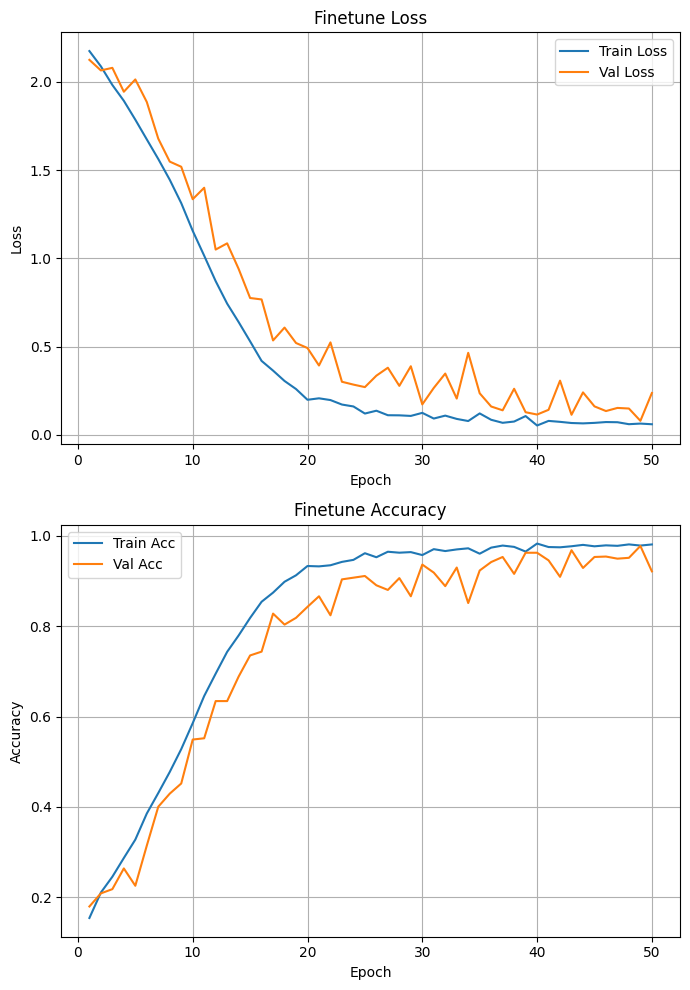

In [15]:
# Plot training curves
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.title("Finetune Loss")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(2,1,2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.title("Finetune Accuracy")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()


Evaluating on test set: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Test metrics:
  Accuracy:  0.9794
  Precision (macro): 0.9819
  Recall (macro):    0.9792
  F1 (macro):        0.9804

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.97      0.98      0.98       133
                  2Abdomen and retroperitoneum       0.99      0.96      0.97       117
                                3cholecystitis       0.99      0.95      0.97       115
      4Membranous and gangrenous cholecystitis       1.00      1.00      1.00       123
                                  5Perforation       1.00      0.98      0.99       106
              6Polyps and cholesterol crystals       0.98      0.99      0.99       102
                              7Adenomyomatosis       0.97      0.97      0.97       116
                                    8Carcinoma       0.94      0.99      0.96       159
9Various causes of gallbladder wall thickening       

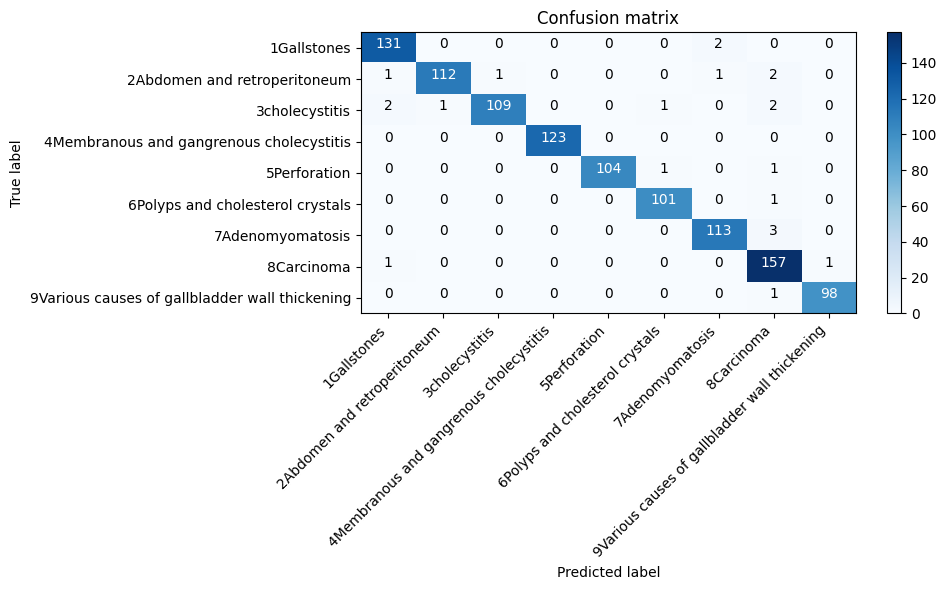

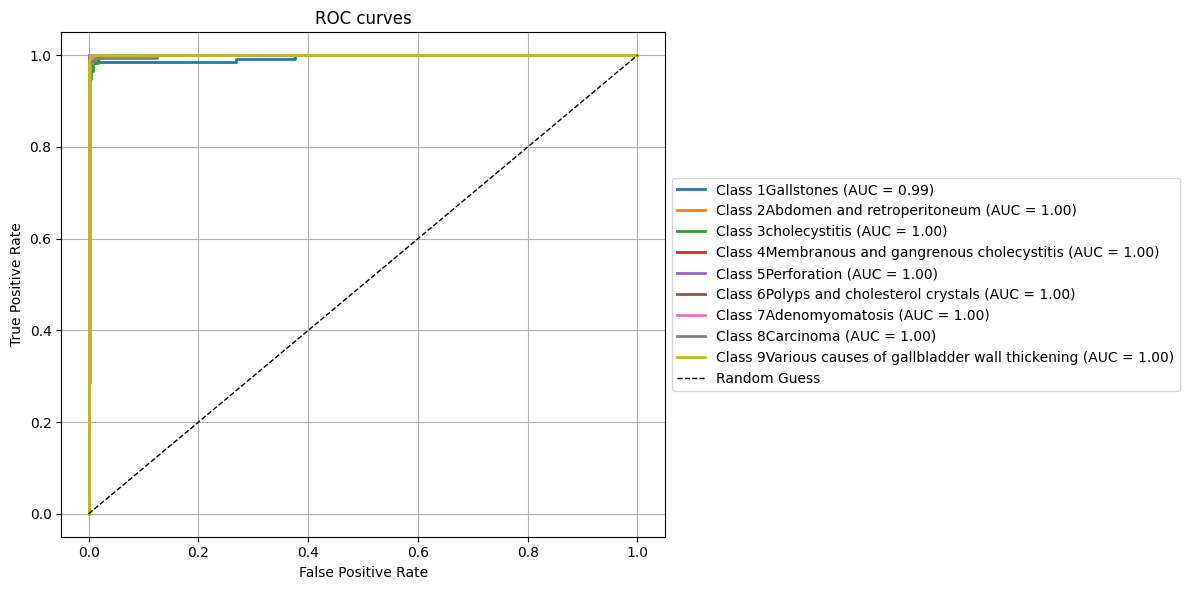

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(FINETUNE_WEIGHTS, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (macro): {precision_macro:.4f}")
print(f"  Recall (macro):    {recall_macro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from  test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.9850
  precision: 1.0000
  recall: 0.9850
  f1_score: 0.9924

Class: 2Abdomen and retroperitoneum
  accuracy: 0.9573
  precision: 1.0000
  recall: 0.9573
  f1_score: 0.9782

Class: 3cholecystitis
  accuracy: 0.9478
  precision: 1.0000
  recall: 0.9478
  f1_score: 0.9732

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 0.9811
  precision: 1.0000
  recall: 0.9811
  f1_score: 0.9905

Class: 6Polyps and cholesterol crystals
  accuracy: 0.9902
  precision: 1.0000
  recall: 0.9902
  f1_score: 0.9951

Class: 7Adenomyomatosis
  accuracy: 0.9741
  precision: 1.0000
  recall: 0.9741
  f1_score: 0.9869

Class: 8Carcinoma
  accuracy: 0.9874
  precision: 1.0000
  recall: 0.9874
  f1_score: 0.9937

Class: 9Various causes of gallbladder wall thickening
  accuracy: 0.9899
  precision: 1.0000
  recall: 0.9899
  f1_score: 0.9949

